This notebook demonstrates Kausal framework on ENSO with real data.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

import xarray as xr
from pathlib import Path

import numpy as np
import pandas as pd
import torch
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt
from matplotlib import cm, colors as mcolors
from matplotlib.collections import LineCollection
from tqdm import tqdm

from kausal.koopman import Kausal
from kausal import stats
from kausal.baselines import magnitude_tigramite, magnitude_varlingam, magnitude_tsci, magnitude_clstm, magnitude_gvar
from kausal.baselines import plot_anomalies_enso, get_anomalies_enso, normalize
from kausal.observables import RandomFourierFeatures, TimeDelayFeatures, MLPFeatures, PolynomialFeatures

import warnings
warnings.filterwarnings('ignore')

/burg/glab/users/jn2808/.conda/envs/kausal/lib/python3.10/site-packages/jaxtyping/__init__.py:244: UserWarning: jaxtyping version >=0.2.23 should be used with Equinox version >=0.11.1
  warnings.warn(
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


# 1. Load dynamics


We use ocean reanalysis dataset processed by https://leap-stc.github.io/ChaosBench/README.html

In [3]:
## CHANGE THIS TO YOUR OWN PATH
dataset_path = Path('/burg/glab/projects/ChaosBench/') 


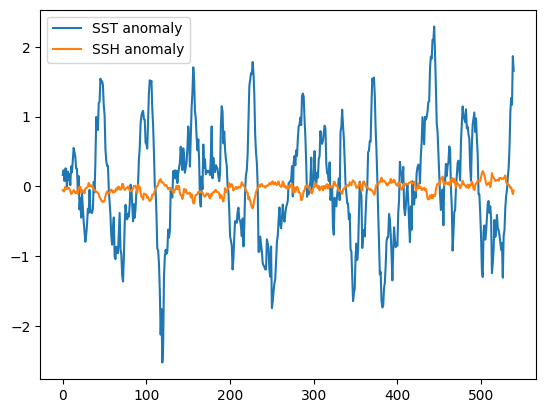

In [4]:
# Load dynamics
oras5_path = dataset_path / 'oras5'
oras5_files = list(oras5_path.glob("oras5_full_1.5deg_*01.zarr"))
oras5_files.sort()

# Load climatology
climatology_path = dataset_path / 'climatology' / 'climatology_oras5_spatial.zarr'
climatology_ds = xr.open_dataset(climatology_path, engine='zarr')

sst_clim = climatology_ds['mean'].sel(param='sosstsst').sel(lat=slice(5, -5), lon=slice(210, 270)).values[5::31]
ssh_clim = climatology_ds['mean'].sel(param='sossheig').sel(lat=slice(5, -5), lon=slice(150, 210)).values[5::31]
sst_anoms_clim = climatology_ds['mean'].sel(param='sosstsst').sel(lat=slice(5, -5), lon=slice(190, 240)).values[5::31]

# Pre-process data
all_sst, all_ssh, all_sst_anoms = [], [], []

for i, oras5_file in enumerate(oras5_files):
    ds = xr.open_dataset(oras5_file, engine='zarr')
    sst = ds['sosstsst'].sel(latitude=slice(5, -5), longitude=slice(210, 270)).values ## Eastern Pacific
    ssh = ds['sossheig'].sel(latitude=slice(5, -5), longitude=slice(150, 210)).values ## Western Pacific
    sst_anoms = ds['sosstsst'].sel(latitude=slice(5, -5), longitude=slice(190, 240)).values ## Nino34 Region

    ## Compute monthly anomalies
    sst = sst[None, ] - sst_clim[i % 12]
    ssh = ssh[None, ] - ssh_clim[i % 12]
    sst_anoms = sst_anoms[None, ] - sst_anoms_clim[i % 12]
    
    all_sst.append(sst.flatten())
    all_ssh.append(ssh.flatten())
    all_sst_anoms.append(sst_anoms.flatten())
    
# Post-process data
omega = torch.tensor([all_sst, all_ssh])
omega = omega.permute(0,2,1).float()

# Plot timeseries on one grid cell
plt.plot(omega[0,0], label='SST anomaly')
plt.plot(omega[1,0], label='SSH anomaly')
plt.legend()
plt.show();


In [5]:
# Additional parameters for plotting
plt.rcParams.update({
    "font.size": 14,                # General font size
    "axes.titlesize": 16,           # Title font size
    "axes.labelsize": 16,           # Axis label font size
    "xtick.labelsize": 12,          # X-axis tick label size
    "ytick.labelsize": 12,          # Y-axis tick label size
    "legend.fontsize": 16,          # Legend font size
    "lines.linewidth": 3,           # Line width
    "figure.dpi": 300,              # Higher DPI for clearer output
})


# 2. Baselines
Available baselines: PCMCI+, VARLiNGAM, TSCI, NeuralGC (cLSTM-variant)

In [6]:
# Parameters
window_length  = 10
tau_max        = 1

# — PCMCI+
causal_effect_pcmciplus = magnitude_tigramite(cause=omega[0:1].mean(axis=1), effect=omega[1:2].mean(axis=1), window_length=window_length, tau_max=tau_max)

# — VARLiNGAM
causal_effect_varlingam = magnitude_varlingam(cause=omega[0:1].mean(axis=1), effect=omega[1:2].mean(axis=1), window_length=window_length, tau_max=tau_max)

# — TSCI
causal_effect_tsci = magnitude_tsci(cause=omega[0:1].mean(axis=1), effect=omega[1:2].mean(axis=1), window_length=window_length, tau_max=tau_max)

# — cLSTM
causal_effect_clstm = magnitude_clstm(cause=omega[0:1].mean(axis=1), effect=omega[1:2].mean(axis=1), window_length=window_length, tau_max=tau_max)


100%|█████████████████████████████████████████████████████████████████████████████████████| 539/539 [04:21<00:00,  2.06it/s]


# 3. Causal Koopman

100%|█████████████████████████████████████████████████████████████████████████████████████| 539/539 [00:52<00:00, 10.29it/s]


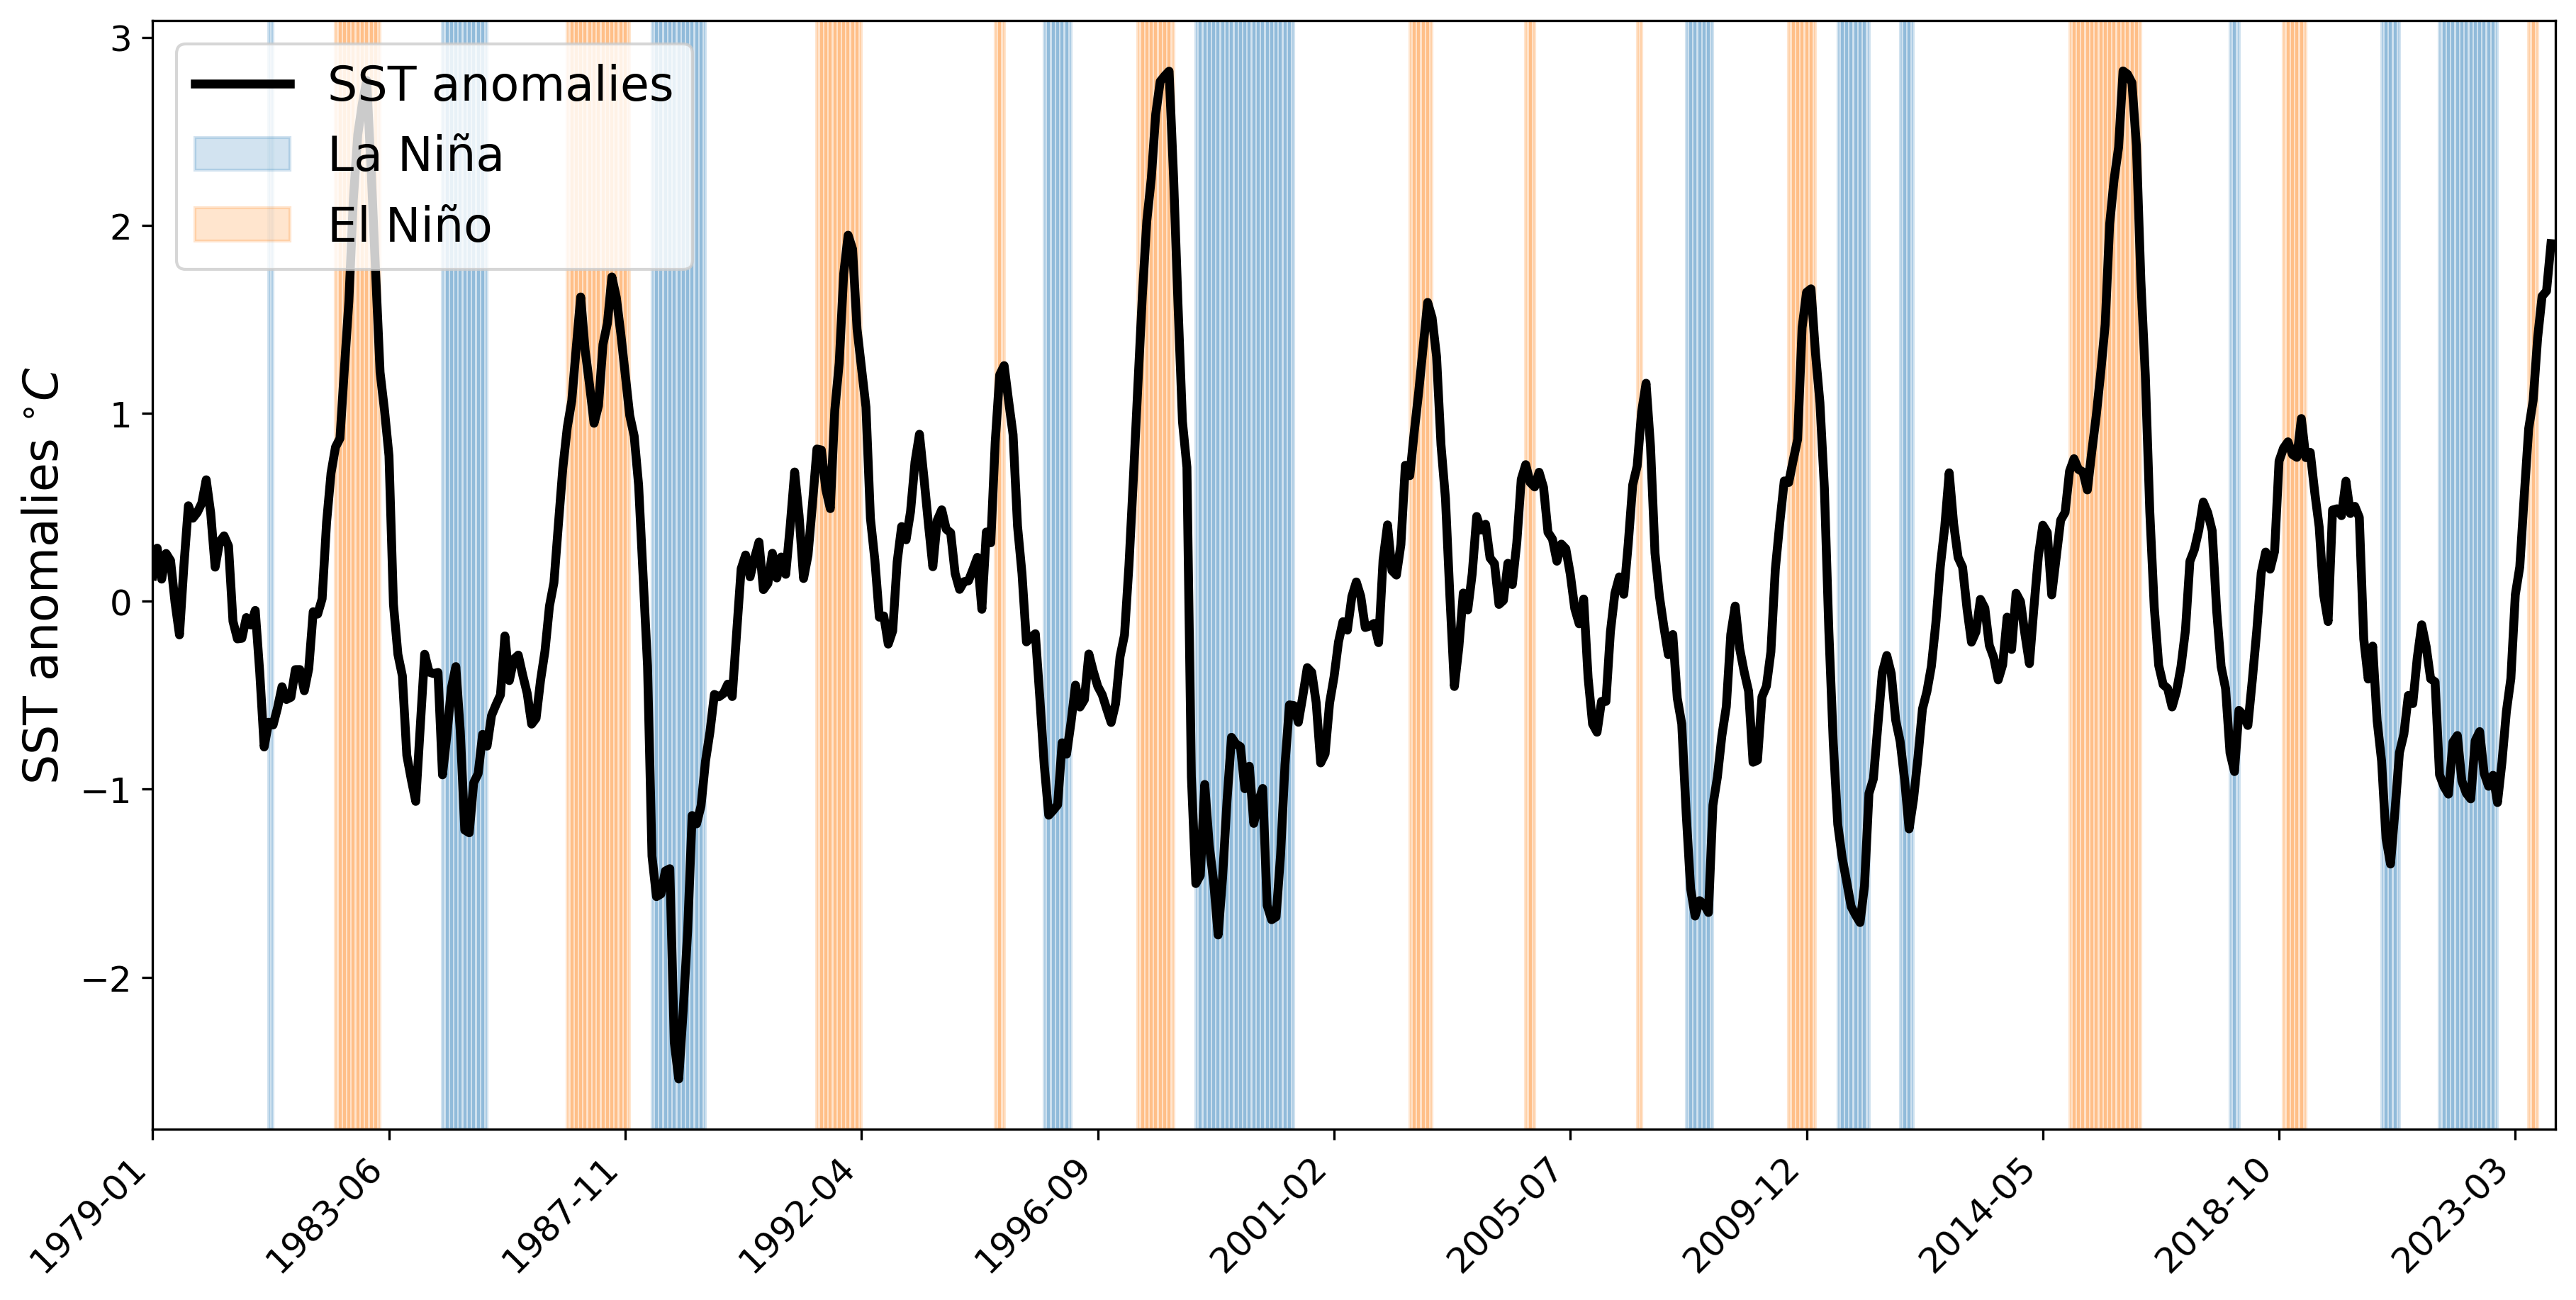

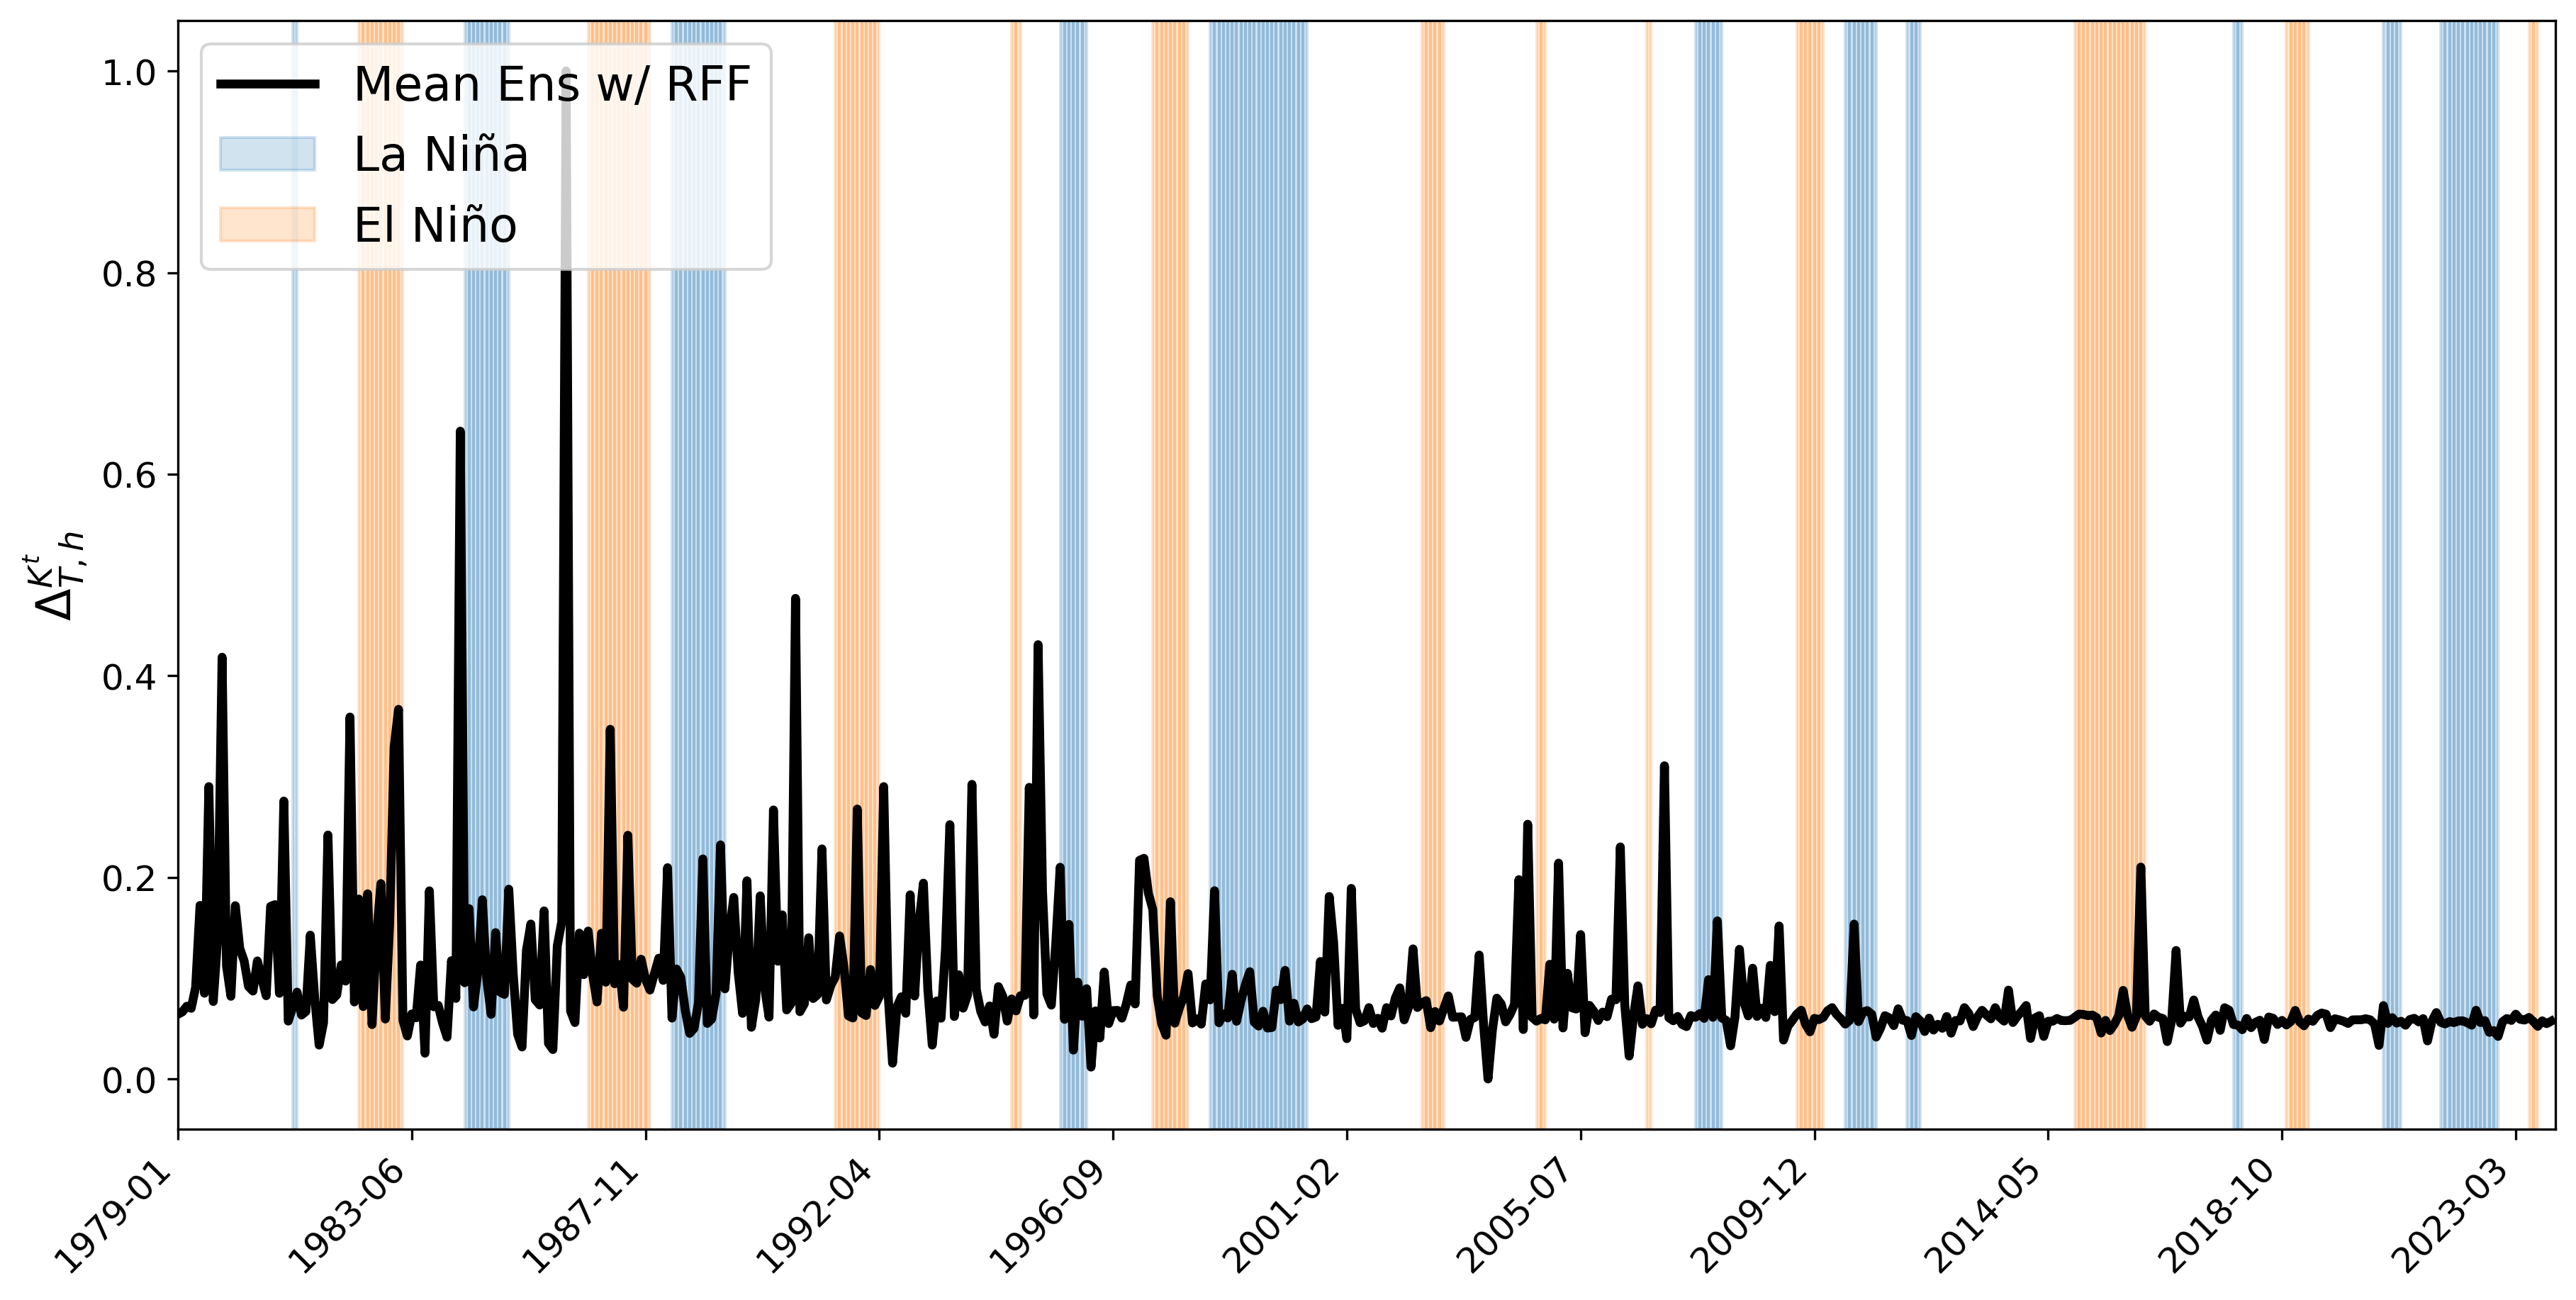

In [7]:
# Causal inference (full) -- RFF
time_shifts = torch.arange(1, 540, 1)
time_idx = torch.arange(len(time_shifts))

# Hyperparameters
n_members = 1

# Cause and effect
cause = omega[0]  ## T
effect = omega[1] ## h

time_to_evals = {0: "1979-01"}
for time_start, start_date in time_to_evals.items():
    dates = pd.date_range(start=start_date, periods=len(time_shifts), freq='ME')
    sst_anomalies = torch.tensor(all_sst_anoms).T.mean(axis=0)[time_idx + time_start]
    
    # Initialize causal Koopman model
    causal_effect_rff = []
    
    for _ in range(n_members):
        causal_koopman = Kausal(
            marginal_observable = RandomFourierFeatures(M=1024),
            joint_observable = RandomFourierFeatures(M=1024),
            cause = cause, effect = effect,
        )
        
        # Perform multistep causal analysis
        causal_effect_rff.append(
            causal_koopman.evaluate_multistep(time_shifts = time_shifts,  init_idx = time_start)
        )
    
    # Plot
    # Subfigure 1: SST anomalies with highlighted regions
    f, ax = plt.subplots(1, 1, figsize=(12, 6), constrained_layout=True)
    ax.plot(sst_anomalies, label='SST anomalies', color='black')
    ax.set_ylabel(r'SST anomalies $^{\circ}C$', size=16)
    ax.set_xlim([time_shifts[0], time_shifts[-1]])
    ax.set_xticks(range(0, len(time_shifts), len(time_shifts) // 10))
    ax.set_xticklabels(dates[::len(time_shifts) // 10].strftime('%Y-%m'), rotation=45, ha='right')
    plot_anomalies_enso(ax=ax, sst_anomalies=sst_anomalies, time_idx=time_idx)
    # f.savefig("docs/enso_sst_anomalies.png", dpi=300, bbox_inches="tight")
    
    # Subfigure 2: Causal effect with highlighted regions
    f, ax = plt.subplots(1, 1, figsize=(12, 6), constrained_layout=True)
    causal_effect_rff = normalize(torch.stack(causal_effect_rff))
    ax.plot(causal_effect_rff.mean(axis=0), color='black', label='Mean Ens w/ RFF')
    ax.fill_between(
        time_idx,
        causal_effect_rff.mean(axis=0) - causal_effect_rff.std(axis=0),
        causal_effect_rff.mean(axis=0) + causal_effect_rff.std(axis=0),
        color=f'black',
        alpha=0.2
    )
    
    ax.set_ylabel(r'$\Delta^{K^t}_{T,h}$', size=16)
    ax.set_xlim([time_shifts[0], time_shifts[-1]])
    ax.set_xticks(range(0, len(time_shifts), len(time_shifts) // 10))
    ax.set_xticklabels(dates[::len(time_shifts) // 10].strftime('%Y-%m'), rotation=45, ha='right')
    plot_anomalies_enso(ax=ax, sst_anomalies=sst_anomalies, time_idx=time_idx)
    # f.savefig("docs/enso_real_rff_expanded.png", dpi=300, bbox_inches="tight");


100%|█████████████████████████████████████████████████████████████████████████████████████| 539/539 [01:21<00:00,  6.59it/s]


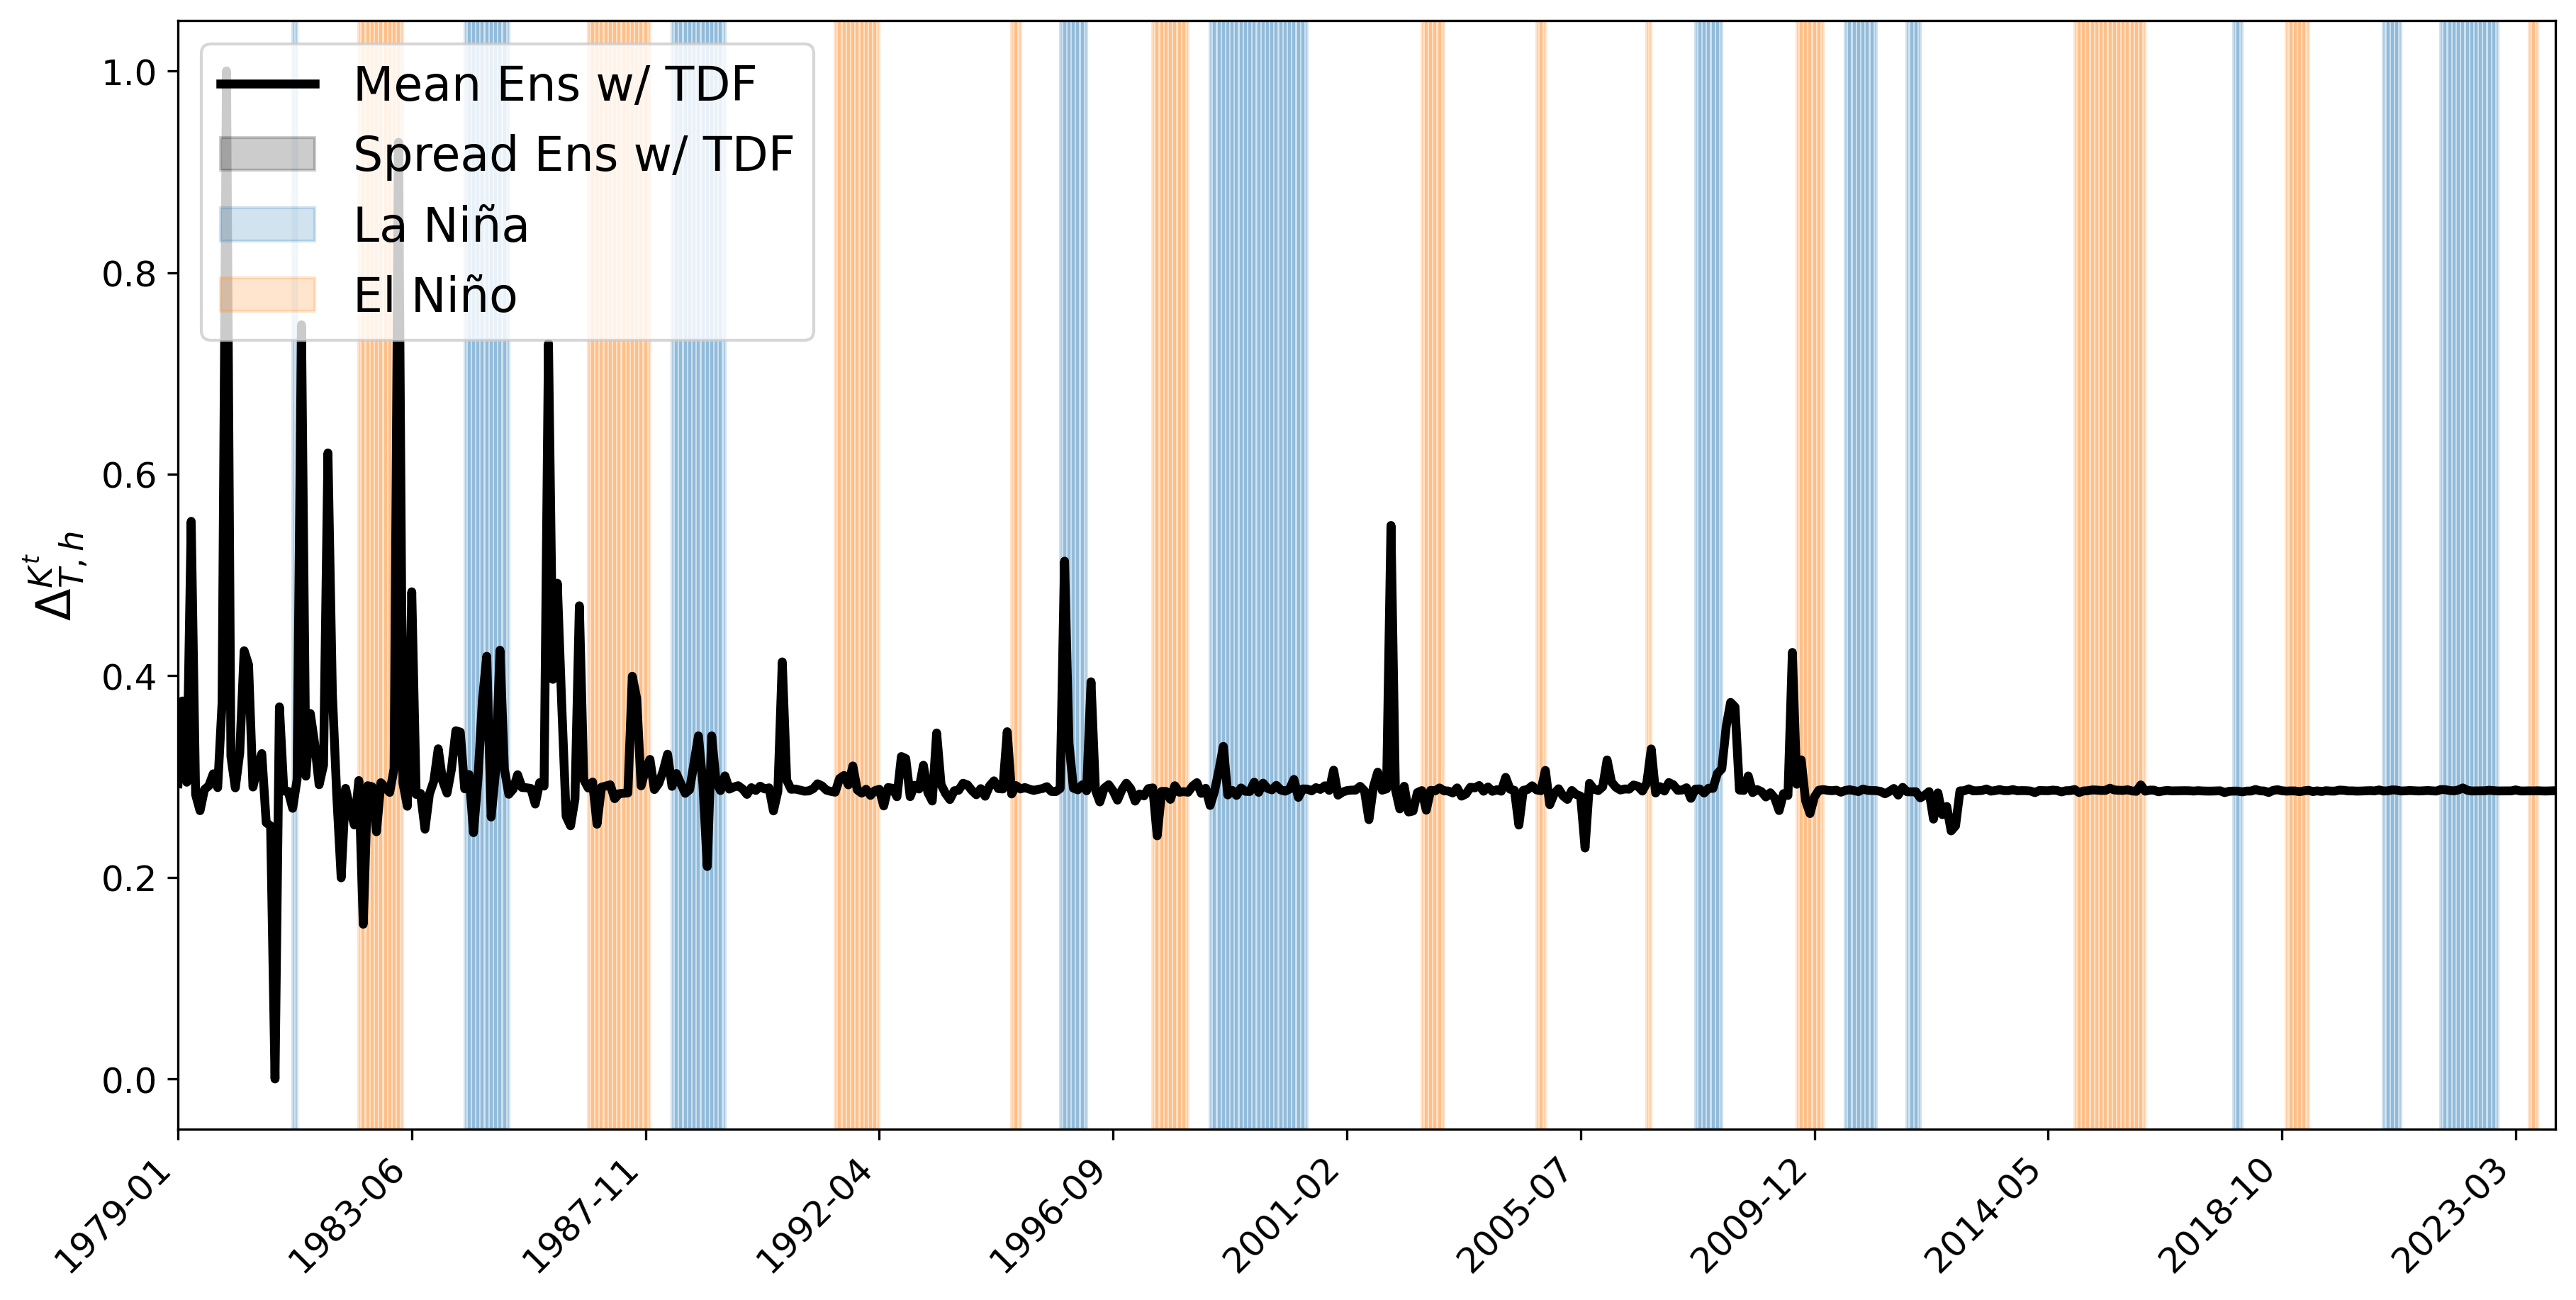

In [8]:
# Causal inference (full) -- TDF
time_shifts = torch.arange(1, 540, 1)
time_idx = torch.arange(len(time_shifts))

# Hyperparameters
n_members = 1

# Cause and effect
cause = omega[0]  ## T
effect = omega[1] ## h

time_to_evals = {0: "1979-01"}
for time_start, start_date in time_to_evals.items():
    dates = pd.date_range(start=start_date, periods=len(time_shifts), freq='ME')
    sst_anomalies = torch.tensor(all_sst_anoms).T.mean(axis=0)[time_idx + time_start]
    
    # Initialize causal Koopman model
    causal_effect_tdf = []
    
    for _ in range(n_members):
        causal_koopman = Kausal(
            marginal_observable = TimeDelayFeatures(n_delays=6),
            joint_observable = TimeDelayFeatures(n_delays=6),
            cause = cause, effect = effect,
        )
        
        # Perform multistep causal analysis
        causal_effect_tdf.append(
            causal_koopman.evaluate_multistep(time_shifts = time_shifts,  init_idx = time_start)
        )
    
    # Plot
    f, ax = plt.subplots(1, 1, figsize=(12, 6), constrained_layout=True)
    causal_effect_tdf = normalize(torch.stack(causal_effect_tdf))
    ax.plot(causal_effect_tdf.mean(axis=0), color='black', label='Mean Ens w/ TDF')
    ax.fill_between(
        time_idx,
        causal_effect_tdf.mean(axis=0) - causal_effect_tdf.std(axis=0),
        causal_effect_tdf.mean(axis=0) + causal_effect_tdf.std(axis=0),
        color=f'black',
        alpha=0.2,
        label=r'Spread Ens w/ TDF'
    )
    
    ax.set_ylabel(r'$\Delta^{K^t}_{T,h}$', size=16)
    ax.set_xlim([time_shifts[0], time_shifts[-1]])
    ax.set_xticks(range(0, len(time_shifts), len(time_shifts) // 10))
    ax.set_xticklabels(dates[::len(time_shifts) // 10].strftime('%Y-%m'), rotation=45, ha='right')
    plot_anomalies_enso(ax=ax, sst_anomalies=sst_anomalies, time_idx=time_idx)
    # f.savefig("docs/enso_real_tdf_expanded.png", dpi=300, bbox_inches="tight");


# 4. Deep Causal Koopman

100%|█████████████████████████████████████████████████████████████████████████████████████| 539/539 [00:49<00:00, 10.88it/s]


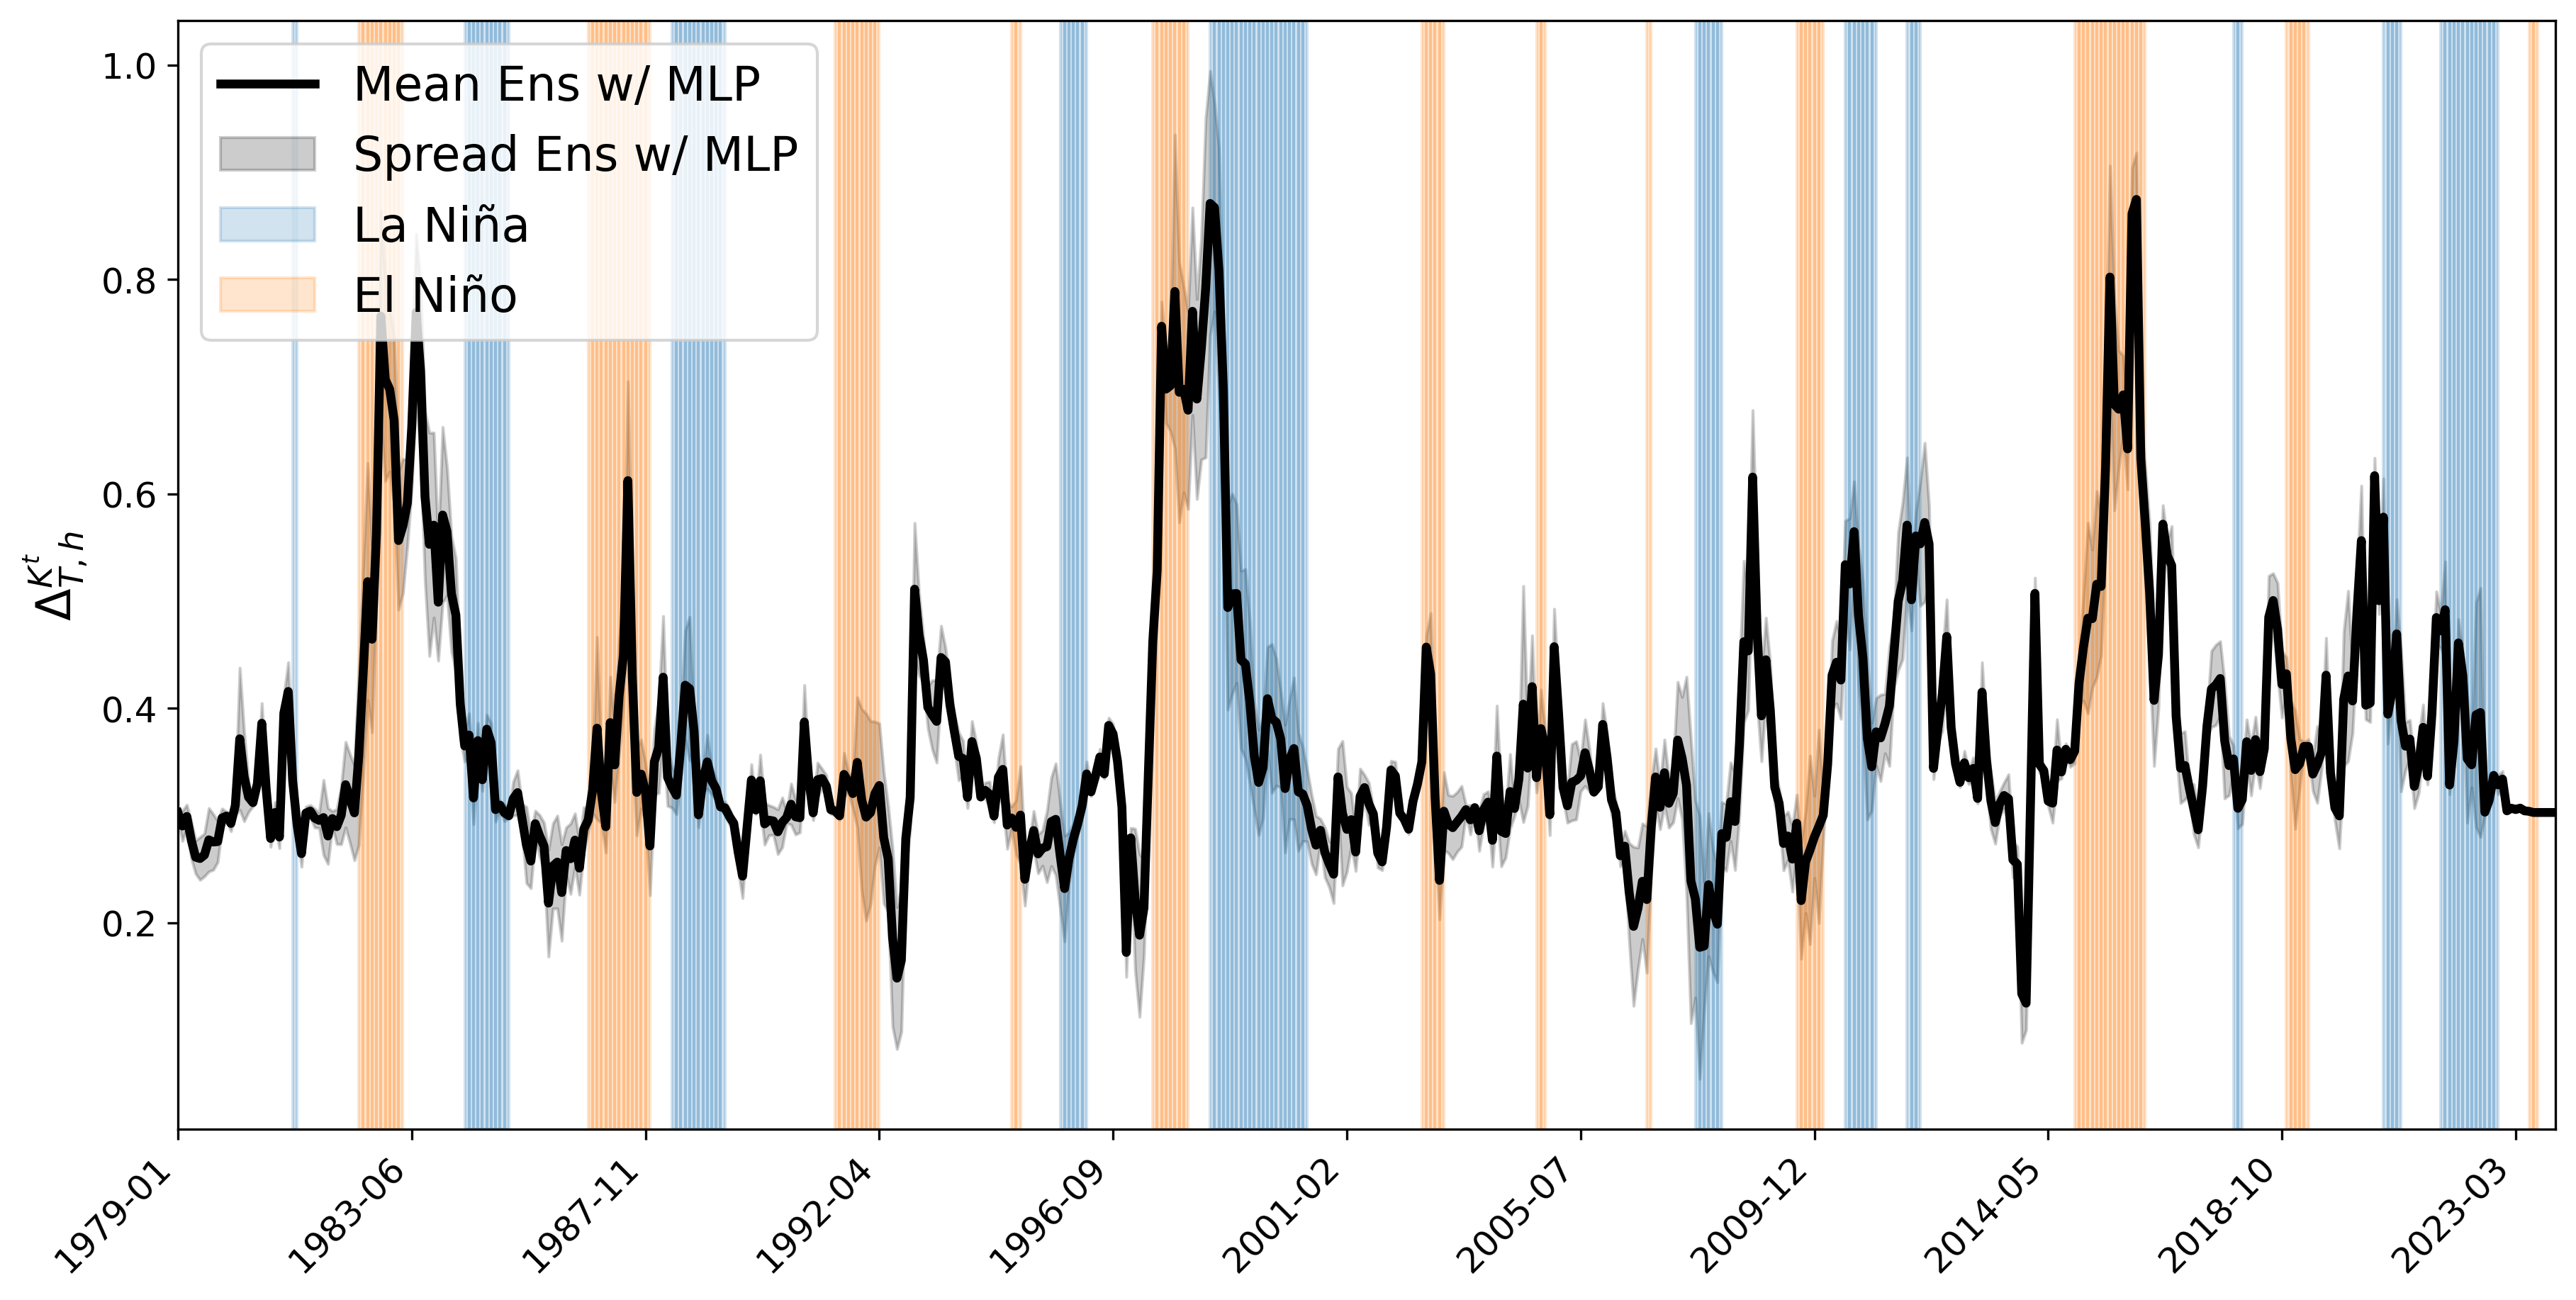

In [9]:
# Causal inference (full)
time_shifts = torch.arange(1, 540, 1)
time_idx = torch.arange(len(time_shifts))

# Hyperparameters
n_members = 5
hidden_channels = [512, 1024]
lr = 1e-2
epochs = 500
n_train = len(oras5_files)

# Cause and effect
cause = omega[0]  ## T
effect = omega[1] ## h

time_to_evals = {0: "1979-01"}
for time_start, start_date in time_to_evals.items():
    dates = pd.date_range(start=start_date, periods=len(time_shifts), freq='ME')
    sst_anomalies = torch.tensor(all_sst_anoms).T.mean(axis=0)[time_idx + time_start]
    
    # Initialize causal Koopman model
    causal_effect_mlp = []
    
    for _ in range(n_members):
        causal_koopman = Kausal(
            marginal_observable = MLPFeatures(
                in_channels=effect.shape[0], hidden_channels = hidden_channels, out_channels=effect.shape[0]
            ),
            
            joint_observable = MLPFeatures(
                in_channels=effect.shape[0] + cause.shape[0], hidden_channels=hidden_channels, out_channels=effect.shape[0]
            ),
            
            cause = cause, effect = effect,
        )
        
        # Fit the observable functions
        _, _ = causal_koopman.fit(n_train=n_train, epochs=epochs, lr=lr, batch_size=n_train)
        
        # Perform multistep causal analysis
        with torch.no_grad():
            causal_effect_mlp.append(
                causal_koopman.evaluate_multistep(time_shifts = time_shifts,  init_idx = time_start)
            )
    
    # Plot
    f, ax = plt.subplots(1, 1, figsize=(12, 6), constrained_layout=True)
    causal_effect_mlp = normalize(torch.stack(causal_effect_mlp))
    ax.plot(causal_effect_mlp.mean(axis=0), color='black', label='Mean Ens w/ MLP')
    ax.fill_between(
        time_idx,
        causal_effect_mlp.mean(axis=0) - causal_effect_mlp.std(axis=0),
        causal_effect_mlp.mean(axis=0) + causal_effect_mlp.std(axis=0),
        color=f'black',
        alpha=0.2,
        label=r'Spread Ens w/ MLP'
    )
    
    ax.set_ylabel(r'$\Delta^{K^t}_{T,h}$', fontsize=16)
    ax.set_xlim([time_shifts[0], time_shifts[-1]])
    ax.set_xticks(range(0, len(time_shifts), len(time_shifts) // 10))
    ax.set_xticklabels(dates[::len(time_shifts) // 10].strftime('%Y-%m'), rotation=45, ha='right')
    plot_anomalies_enso(ax=ax, sst_anomalies=sst_anomalies, time_idx=time_idx)
    # f.savefig("docs/enso_real_mlp_expanded.png", dpi=300, bbox_inches="tight");


# 5. Additional Experiments

For simplicity, we overlay causal measures between RFF and MLP.

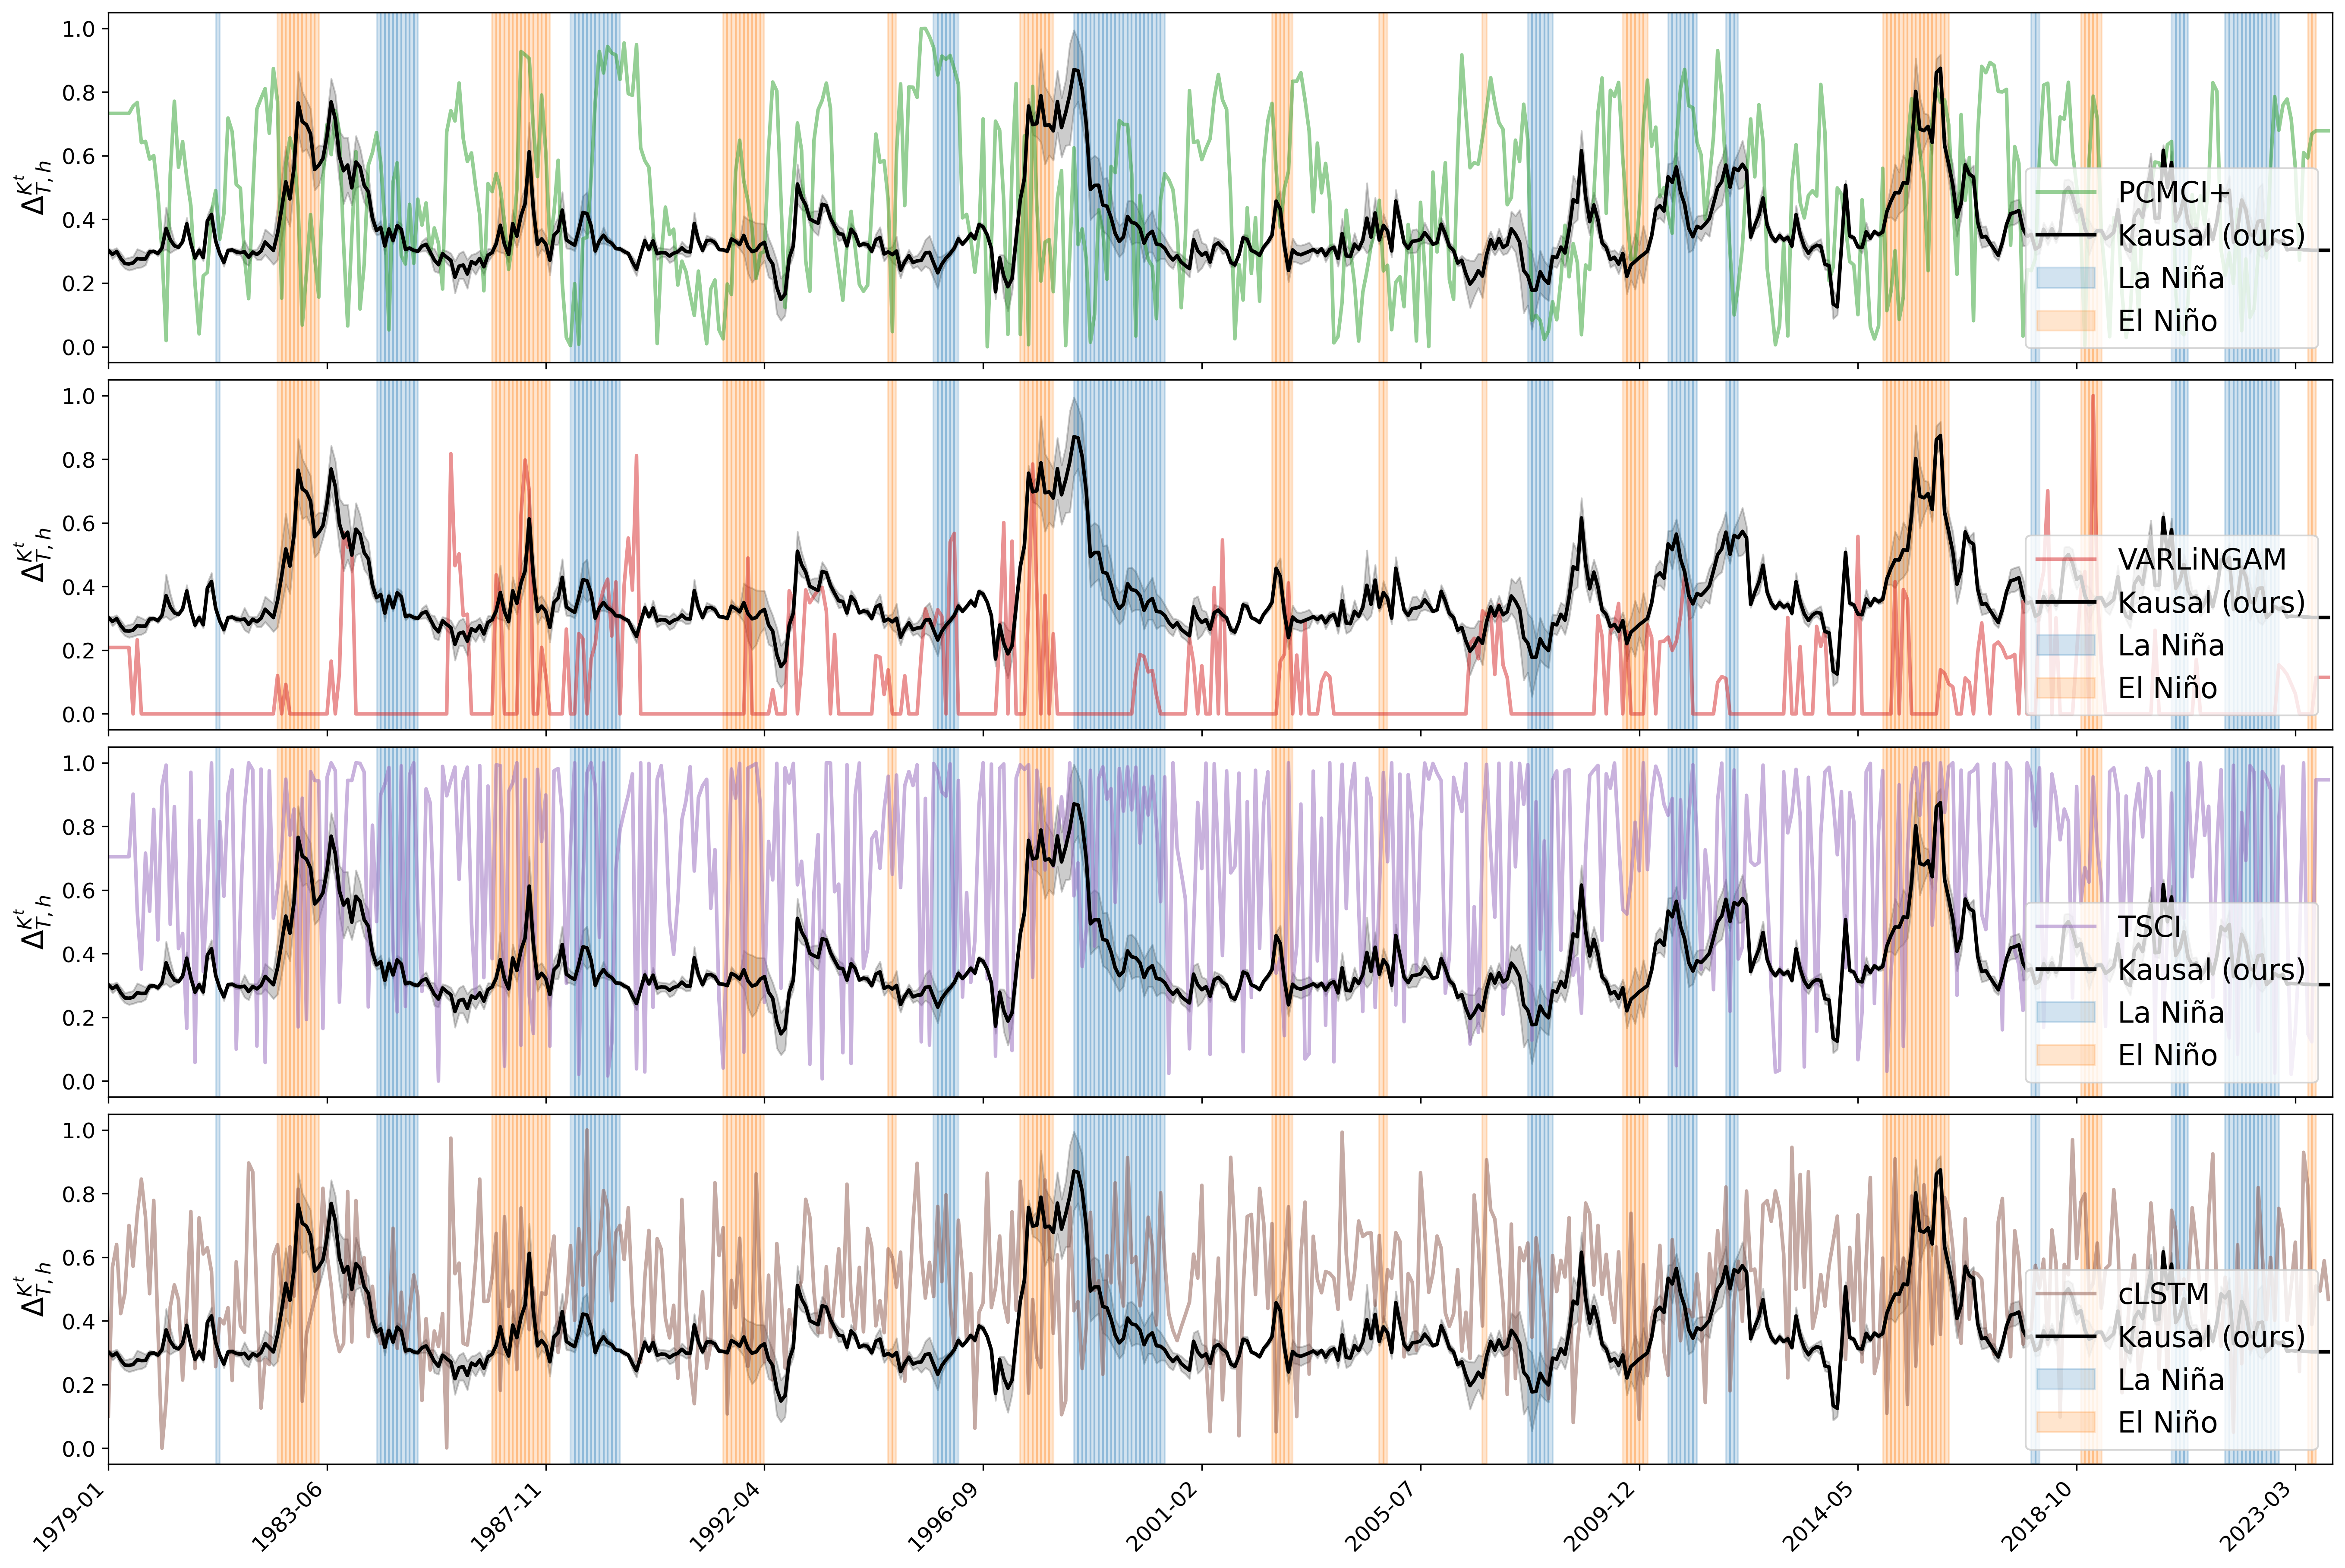

In [10]:
# Overlay baselines
baselines = [
    ("PCMCI+", causal_effect_pcmciplus, 'C2'),
    ("VARLiNGAM", causal_effect_varlingam, 'C3'),
    ("TSCI", causal_effect_tsci, 'C4'),
    ("cLSTM", causal_effect_clstm, 'C5')
]

fig, axes = plt.subplots(len(baselines), 1, figsize=(18, 3*len(baselines)), sharex=True, sharey=True, constrained_layout=True)
axes = axes.flatten()

# For each baseline, plot the baseline and Kausal on the same subplot.
for ax, (label, baseline, color) in zip(axes, baselines):
    # Plot the baseline causal effect
    ax.plot(baseline, color=color, linestyle='solid', alpha=0.5, label=label, linewidth=2)
    kausal_mean = causal_effect_mlp.mean(axis=0)
    ax.plot(kausal_mean, color='black', linestyle='solid', alpha=1.0, label='Kausal (ours)', linewidth=2)
    ax.fill_between(
        time_idx,
        kausal_mean - causal_effect_mlp.std(axis=0),
        kausal_mean + causal_effect_mlp.std(axis=0),
        color='black',
        alpha=0.2,
    )
    
    ax.set_ylabel(r'$\Delta^{K^t}_{T,h}$', size=16)
    ax.set_xlim([time_shifts[0], time_shifts[-1]])
    ax.set_xticks(range(0, len(time_shifts), len(time_shifts) // 10))
    ax.set_xticklabels(dates[::len(time_shifts) // 10].strftime('%Y-%m'), rotation=45, ha='right')
    
    # Overlay ENSO anomalies in background
    plot_anomalies_enso(ax=ax, sst_anomalies=sst_anomalies, time_idx=time_idx)
    ax.legend(loc='lower right')

plt.show()
# fig.savefig("docs/enso_real_baselines_estimation.png", dpi=300, bbox_inches="tight");


In [11]:
# Overlay Kausal variants
baselines = [
    ("Kausal (TDF)", causal_effect_tdf.mean(axis=0), 'C2'),
    ("Kausal (RFF)", causal_effect_rff.mean(axis=0), 'C3'),
]

fig, axes = plt.subplots(2, 1, figsize=(18, 6), sharex=True, sharey=True, constrained_layout=True)
axes = axes.flatten()

# For each baseline, plot the baseline and Kausal on the same subplot.
for ax, (label, baseline, color) in zip(axes, baselines):
    # Plot the baseline causal effect
    ax.plot(baseline, color=color, linestyle='solid', alpha=0.5, label=label, linewidth=2)
    kausal_mean = causal_effect_mlp.mean(axis=0)
    ax.plot(kausal_mean, color='black', linestyle='solid', alpha=1.0, label='Kausal (MLP)', linewidth=2)
    ax.fill_between(
        time_idx,
        kausal_mean - causal_effect_mlp.std(axis=0),
        kausal_mean + causal_effect_mlp.std(axis=0),
        color='black',
        alpha=0.2,
    )
    
    ax.set_ylabel(r'$\Delta^{K^t}_{T,h}$', size=16)
    ax.set_xlim([time_shifts[0], time_shifts[-1]])
    ax.set_xticks(range(0, len(time_shifts), len(time_shifts) // 10))
    ax.set_xticklabels(dates[::len(time_shifts) // 10].strftime('%Y-%m'), rotation=45, ha='right')
    
    # Overlay ENSO anomalies in background
    plot_anomalies_enso(ax=ax, sst_anomalies=sst_anomalies, time_idx=time_idx)
    ax.legend(loc='lower right')

plt.show()
# fig.savefig("docs/enso_real_kausal_estimation.png", dpi=300, bbox_inches="tight");


In [12]:
# AUROC baselines
enso_events = get_anomalies_enso(sst_anomalies, time_idx)
y_true = enso_events.astype(int)
y_scores = [causal_effect_mlp.mean(axis=0), causal_effect_pcmciplus, causal_effect_varlingam, causal_effect_tsci, causal_effect_clstm]
labels = ['Chance', 'Kausal (MLP)', 'PCMCI+', 'VARLiNGAM', 'TSCI', 'cLSTM']
colors = ['lightgrey', 'black', 'C2', 'C3', 'C4', 'C5', 'C6']

plt.figure(figsize=(4,4))
for i, y_score in enumerate(y_scores, 1):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, color=colors[i], label=f'{labels[i]} (AUC={roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right", fontsize=8)
# plt.savefig("docs/enso_real_baselines_auroc.png", dpi=300, bbox_inches="tight")
plt.show();


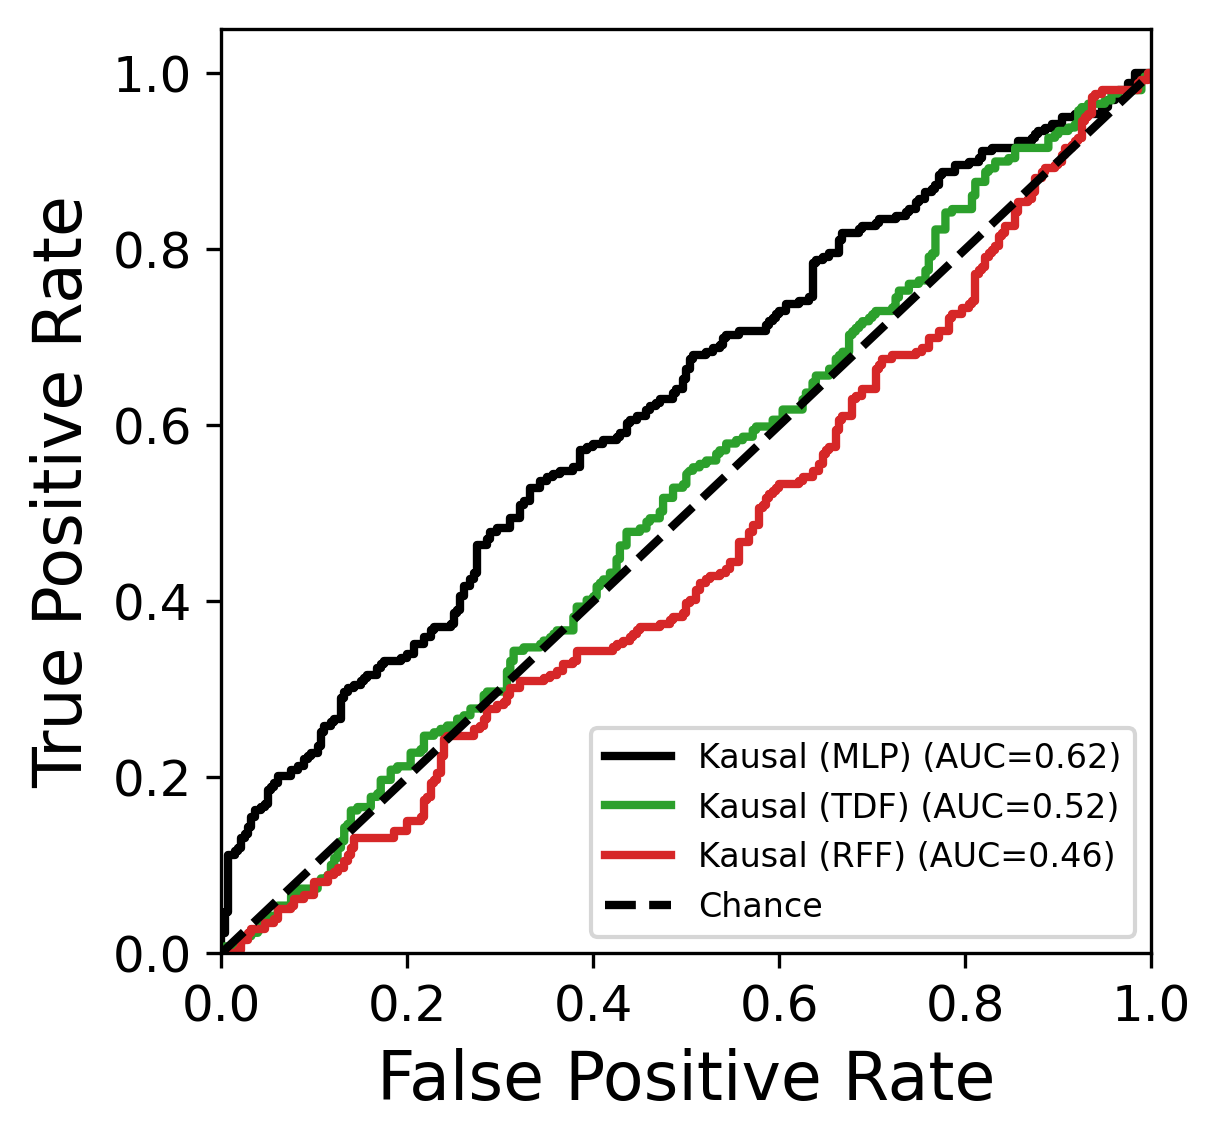

In [13]:
# AUROC Kausal variants
enso_events = get_anomalies_enso(sst_anomalies, time_idx)
y_true = enso_events.astype(int)
y_scores = [causal_effect_mlp.mean(axis=0), causal_effect_tdf.mean(axis=0), causal_effect_rff.mean(axis=0)]
labels = ['Chance', 'Kausal (MLP)', 'Kausal (TDF)', 'Kausal (RFF)']
colors = ['lightgrey', 'black', 'C2', 'C3']

plt.figure(figsize=(4,4))
for i, y_score in enumerate(y_scores, 1):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, color=colors[i], label=f'{labels[i]} (AUC={roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right", fontsize=8)
# plt.savefig("docs/enso_real_kausal_auroc.png", dpi=300, bbox_inches="tight")
plt.show();
